# Part I - Download Pre-Trained GloVe Embeddings

In [1]:
# Gather embeddings via chakin
# Following methods described in
#    https://github.com/chakki-works/chakin

import numpy as np
import tensorflow as tf

# Python chakin package previously installed by 
#    pip install chakin
import chakin  
import json
import os
from collections import defaultdict

os.chdir('C:\\Users\\A4 Dell\\Desktop\\Northwestern University\\Practical Machine Learning\\week8')
chakin.search(lang='English')  # lists available indices in English

                   Name  Dimension                     Corpus VocabularySize  \
2          fastText(en)        300                  Wikipedia           2.5M   
11         GloVe.6B.50d         50  Wikipedia+Gigaword 5 (6B)           400K   
12        GloVe.6B.100d        100  Wikipedia+Gigaword 5 (6B)           400K   
13        GloVe.6B.200d        200  Wikipedia+Gigaword 5 (6B)           400K   
14        GloVe.6B.300d        300  Wikipedia+Gigaword 5 (6B)           400K   
15       GloVe.42B.300d        300          Common Crawl(42B)           1.9M   
16      GloVe.840B.300d        300         Common Crawl(840B)           2.2M   
17    GloVe.Twitter.25d         25               Twitter(27B)           1.2M   
18    GloVe.Twitter.50d         50               Twitter(27B)           1.2M   
19   GloVe.Twitter.100d        100               Twitter(27B)           1.2M   
20   GloVe.Twitter.200d        200               Twitter(27B)           1.2M   
21  word2vec.GoogleNews        300      

In [2]:
CHAKIN_INDEX = 11
NUMBER_OF_DIMENSIONS = 50
SUBFOLDER_NAME = "gloVe.6B"

DATA_FOLDER = "embeddings"
ZIP_FILE = os.path.join(DATA_FOLDER, "{}.zip".format(SUBFOLDER_NAME))
ZIP_FILE_ALT = "glove" + ZIP_FILE[5:]  # sometimes it's lowercase only...
UNZIP_FOLDER = os.path.join(DATA_FOLDER, SUBFOLDER_NAME)
if SUBFOLDER_NAME[-1] == "d":
    GLOVE_FILENAME = os.path.join(
        UNZIP_FOLDER, "{}.txt".format(SUBFOLDER_NAME))
else:
    GLOVE_FILENAME = os.path.join(UNZIP_FOLDER, "{}.{}d.txt".format(
        SUBFOLDER_NAME, NUMBER_OF_DIMENSIONS))

In [3]:
if not os.path.exists(ZIP_FILE) and not os.path.exists(UNZIP_FOLDER):
    # GloVe by Stanford is licensed Apache 2.0:
    #     https://github.com/stanfordnlp/GloVe/blob/master/LICENSE
    #     http://nlp.stanford.edu/data/glove.twitter.27B.zip
    #     Copyright 2014 The Board of Trustees of The Leland Stanford Junior University
    print("Downloading embeddings to '{}'".format(ZIP_FILE))
    chakin.download(number=CHAKIN_INDEX, save_dir='./{}'.format(DATA_FOLDER))
else:
    print("Embeddings already downloaded.")

if not os.path.exists(UNZIP_FOLDER):
    import zipfile
    if not os.path.exists(ZIP_FILE) and os.path.exists(ZIP_FILE_ALT):
        ZIP_FILE = ZIP_FILE_ALT
    with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
        print("Extracting embeddings to '{}'".format(UNZIP_FOLDER))
        zip_ref.extractall(UNZIP_FOLDER)
else:
    print("Embeddings already extracted.")

print('\nRun complete')

Embeddings already downloaded.
Embeddings already extracted.

Run complete


# Part II - Data Preparation to Read in Movie Reviews

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

## Plot
from matplotlib import pyplot

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TreebankWordTokenizer

# Other
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [5]:
REMOVE_STOPWORDS = False  # no stopword removal 

In [6]:
# ------------------------------------------------------------
# code for working with movie reviews data 
# Source: Miller, T. W. (2016). Web and Network Data Science.

# This original study used a simple bag-of-words approach
# to sentiment analysis, along with pre-defined lists of
# negative and positive words.        
# Code available at:  https://github.com/mtpa/wnds       
# ------------------------------------------------------------
# Utility function to get file names within a directory
def listdir_no_hidden(path):
    start_list = os.listdir(path)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file)
    return(end_list)

# define list of codes to be dropped from document
# carriage-returns, line-feeds, tabs
codelist = ['\r', '\n', '\t']   

# We will not remove stopwords in this exercise because they are
# important to keeping sentences intact
if REMOVE_STOPWORDS:
    print(nltk.corpus.stopwords.words('english'))

# previous analysis of a list of top terms showed a number of words, along 
# with contractions and other word strings to drop from further analysis, add
# these to the usual English stopwords to be dropped from a document collection
    more_stop_words = ['cant','didnt','doesnt','dont','goes','isnt','hes',\
        'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
        've', 're', 'vs'] 

    some_proper_nouns_to_remove = ['dick','ginger','hollywood','jack',\
        'jill','john','karloff','kudrow','orson','peter','tcm','tom',\
        'toni','welles','william','wolheim','nikita']

    # start with the initial list and add to it for movie text work 
    stoplist = nltk.corpus.stopwords.words('english') + more_stop_words +\
        some_proper_nouns_to_remove

In [7]:
# text parsing function for creating text documents 
def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z]', '  ', string)    
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = ' ' + codelist[i] + '  '
        temp_string = re.sub(stopstring, '  ', temp_string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()    
    if REMOVE_STOPWORDS:
        # replace selected character strings/stop-words with space
        for i in range(len(stoplist)):
            stopstring = ' ' + str(stoplist[i]) + ' '
            temp_string = re.sub(stopstring, ' ', temp_string)        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string)    

In [8]:
# -----------------------------------------------
# gather data for 500 negative movie reviews
# -----------------------------------------------
dir_name = 'movie-reviews-negative'
    
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))

# Read data for negative movie reviews
# Data will be stored in a list of lists where the each list represents 
# a document and document is a list of words.
# We then break the text into words.

def read_data(filename):
  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

negative_documents = []

print('\nProcessing document files under', dir_name)
for i in range(num_files):
    #print(' ', filenames[i])
    words = read_data(os.path.join(dir_name, filenames[i]))
    negative_documents.append(words)


Directory: movie-reviews-negative
500 files found

Processing document files under movie-reviews-negative


In [9]:
# -----------------------------------------------
# gather data for 500 positive movie reviews
# -----------------------------------------------
dir_name = 'movie-reviews-positive'  
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))

# Read data for positive movie reviews
def read_data(filename):
  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

positive_documents = []

print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ##print(' ', filenames[i])
    words = read_data(os.path.join(dir_name, filenames[i]))
    positive_documents.append(words)


Directory: movie-reviews-positive
500 files found

Processing document files under movie-reviews-positive


In [10]:
# -----------------------------------------------------
# convert positive/negative documents into numpy array
# note that reviews vary from 22 to 1052 words   
# so we use the first 20 and last 20 words of each review 
# as our word sequences for analysis
# -----------------------------------------------------
max_review_length = 0  # initialize
for doc in negative_documents:
    max_review_length = max(max_review_length, len(doc))    
for doc in positive_documents:
    max_review_length = max(max_review_length, len(doc)) 
print('max_review_length:', max_review_length) 

min_review_length = max_review_length  # initialize
for doc in negative_documents:
    min_review_length = min(min_review_length, len(doc))    
for doc in positive_documents:
    min_review_length = min(min_review_length, len(doc)) 
print('min_review_length:', min_review_length) 

# construct list of 1000 lists with 40 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    

max_review_length: 1052
min_review_length: 22


# Part III - Get Word Embeddings from GloVe (50d)

Tokenize the text data and convert those into sequences. 

In [11]:
vocabulary_size = 10000   #specify desired size of pre-defined embedding vocabulary 

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(documents)

# integer encode the documents
sequences = tokenizer.texts_to_sequences(documents)
embeddings = pad_sequences(sequences, maxlen=50)

In [12]:
embeddings_index = dict()
f = open('embeddings/gloVe.6B/glove.6B.50d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [13]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 50))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [14]:
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
RANDOM_SEED = 9999

embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [15]:
X_train.shape

(800, 50)

In [16]:
y_train.shape

(800,)

# Part IV - Build RNN Model

In [38]:
model = Sequential()
model.add(Embedding(vocabulary_size, 50, input_length=50, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 50)            500000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 46, 64)            16064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 539,115
Trainable params: 39,115
Non-trainable params: 500,000
_________________________________________________________________

In [39]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 4s 5ms/step - loss: 0.6930 - acc: 0.5062 - val_loss: 0.6940 - val_acc: 0.4700
Epoch 2/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6928 - acc: 0.5100 - val_loss: 0.6930 - val_acc: 0.4750
Epoch 3/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5162 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 4/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6893 - acc: 0.5150 - val_loss: 0.6921 - val_acc: 0.4700
Epoch 5/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6845 - acc: 0.5887 - val_loss: 0.6860 - val_acc: 0.6650
Epoch 6/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6751 - acc: 0.6412 - val_loss: 0.6708 - val_acc: 0.6600
Epoch 7/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6615 - acc: 0.6050 - val_loss: 0.6593 - val_acc: 0.6350
Epoch 8/30
800/800 [==========

In [40]:
batch_size = 64

score, acc = model.evaluate(X_train, y_train, batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

800/800 [==============================] - 0s 299us/step
Train score: 0.045682898312807085
Train accuracy: 1.0
200/200 [==============================] - 0s 335us/step
Test score: 0.6553141331672668
Test accuracy: 0.64


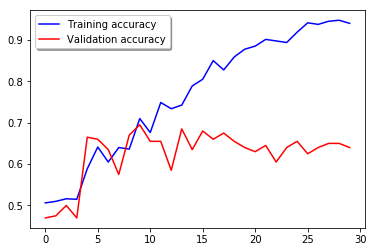

In [41]:
# Plot the accuracy curves for training and validation 
pyplot.plot(history.history['acc'], color='b', label="Training accuracy")
pyplot.plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = pyplot.legend(loc='best', shadow=True)

# Increase Vocabulary Size and Run Model Again (50d)

In [42]:
vocabulary_size = 30000   #specify desired size of pre-defined embedding vocabulary 

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(documents)

# integer encode the documents
sequences = tokenizer.texts_to_sequences(documents)
embeddings = pad_sequences(sequences, maxlen=50)

In [43]:
embeddings_index = dict()
f = open('embeddings/gloVe.6B/glove.6B.50d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 50))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Loaded 400000 word vectors.


In [44]:
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
RANDOM_SEED = 9999

embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [45]:
model = Sequential()
model.add(Embedding(vocabulary_size, 50, input_length=50, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 50)            1500000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 46, 64)            16064     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 1,539,115
Trainable params: 39,115
Non-trainable params: 1,500,000
_____________________________________________________________

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 4s 5ms/step - loss: 0.6949 - acc: 0.5150 - val_loss: 0.6925 - val_acc: 0.5600
Epoch 2/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6919 - acc: 0.5500 - val_loss: 0.6923 - val_acc: 0.5400
Epoch 3/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6912 - acc: 0.5275 - val_loss: 0.6912 - val_acc: 0.5650
Epoch 4/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6897 - acc: 0.5725 - val_loss: 0.6903 - val_acc: 0.5650
Epoch 5/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6852 - acc: 0.6112 - val_loss: 0.6857 - val_acc: 0.5900
Epoch 6/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6769 - acc: 0.5950 - val_loss: 0.6782 - val_acc: 0.5900
Epoch 7/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6663 - acc: 0.6150 - val_loss: 0.6775 - val_acc: 0.5600
Epoch 8/30
800/800 [==========

800/800 [==============================] - 0s 339us/step
Train score: 0.03004296436905861
Train accuracy: 1.0
200/200 [==============================] - 0s 405us/step
Test score: 0.8699655938148498
Test accuracy: 0.63


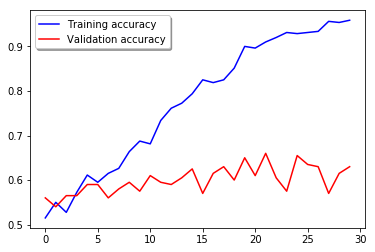

In [47]:
score, acc = model.evaluate(X_train, y_train, batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Plot the accuracy curves for training and validation 
pyplot.plot(history.history['acc'], color='b', label="Training accuracy")
pyplot.plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = pyplot.legend(loc='best', shadow=True)

# Part V - Use GloVe Embeddings 100d

In [48]:
vocabulary_size = 10000   #specify desired size of pre-defined embedding vocabulary 

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(documents)

# integer encode the documents
sequences = tokenizer.texts_to_sequences(documents)
embeddings = pad_sequences(sequences, maxlen=50)

embeddings_index = dict()
f = open('embeddings/gloVe.6B/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Loaded 400000 word vectors.


In [49]:
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
RANDOM_SEED = 9999

embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [50]:
model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=50, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 1,098,165
Trainable params: 98,165
Non-trainable params: 1,000,000
_____________________________________________________________

In [51]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 5s 6ms/step - loss: 0.6971 - acc: 0.4675 - val_loss: 0.6949 - val_acc: 0.4700
Epoch 2/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6916 - acc: 0.5038 - val_loss: 0.6928 - val_acc: 0.4700
Epoch 3/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6879 - acc: 0.5513 - val_loss: 0.6894 - val_acc: 0.5850
Epoch 4/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6748 - acc: 0.6163 - val_loss: 0.6672 - val_acc: 0.6200
Epoch 5/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6284 - acc: 0.6812 - val_loss: 0.6636 - val_acc: 0.6050
Epoch 6/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6037 - acc: 0.6737 - val_loss: 0.6361 - val_acc: 0.6400
Epoch 7/30
800/800 [==============================] - 1s 1ms/step - loss: 0.5646 - acc: 0.7050 - val_loss: 0.6642 - val_acc: 0.5900
Epoch 8/30
800/800 [==========

800/800 [==============================] - 0s 476us/step
Train score: 0.005581369437277317
Train accuracy: 1.0
200/200 [==============================] - 0s 380us/step
Test score: 0.7610415077209473
Test accuracy: 0.7


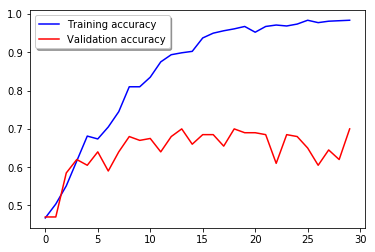

In [52]:
score, acc = model.evaluate(X_train, y_train, batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Plot the accuracy curves for training and validation 
pyplot.plot(history.history['acc'], color='b', label="Training accuracy")
pyplot.plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = pyplot.legend(loc='best', shadow=True)

# Increase Vocabulary Size and Run Model Again (100d)

In [53]:
vocabulary_size = 30000   #specify desired size of pre-defined embedding vocabulary 

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(documents)

# integer encode the documents
sequences = tokenizer.texts_to_sequences(documents)
embeddings = pad_sequences(sequences, maxlen=50)

embeddings_index = dict()
f = open('embeddings/gloVe.6B/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Loaded 400000 word vectors.


In [54]:
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
RANDOM_SEED = 9999

embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [55]:
model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=50, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 100)           3000000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 3,098,165
Trainable params: 98,165
Non-trainable params: 3,000,000
_____________________________________________________________

In [56]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 5s 6ms/step - loss: 0.6933 - acc: 0.4975 - val_loss: 0.6934 - val_acc: 0.4700
Epoch 2/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6906 - acc: 0.5463 - val_loss: 0.6882 - val_acc: 0.6900
Epoch 3/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6832 - acc: 0.6050 - val_loss: 0.6764 - val_acc: 0.6800
Epoch 4/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6506 - acc: 0.6663 - val_loss: 0.6618 - val_acc: 0.5500
Epoch 5/30
800/800 [==============================] - 1s 1ms/step - loss: 0.6184 - acc: 0.6737 - val_loss: 0.6334 - val_acc: 0.6300
Epoch 6/30
800/800 [==============================] - 1s 1ms/step - loss: 0.5898 - acc: 0.6812 - val_loss: 0.6422 - val_acc: 0.5950
Epoch 7/30
800/800 [==============================] - 1s 1ms/step - loss: 0.5508 - acc: 0.7238 - val_loss: 0.6230 - val_acc: 0.6500
Epoch 8/30
800/800 [==========

800/800 [==============================] - 0s 346us/step
Train score: 0.0030899309739470483
Train accuracy: 1.0
200/200 [==============================] - 0s 435us/step
Test score: 0.8571990966796875
Test accuracy: 0.65


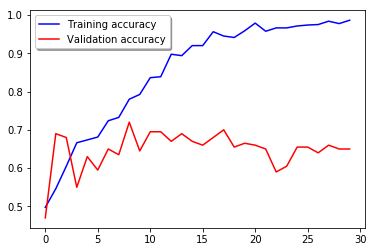

In [57]:
score, acc = model.evaluate(X_train, y_train, batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Plot the accuracy curves for training and validation 
pyplot.plot(history.history['acc'], color='b', label="Training accuracy")
pyplot.plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = pyplot.legend(loc='best', shadow=True)

# Modify Model Hyperparameter Setting (100d)

In [69]:
# compile model
opt = optimizers.Adam(lr=1e-5)
model.compile(loss='binary_crossentropy',
              optimizer=opt,   
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 5s 6ms/step - loss: 0.0446 - acc: 0.9775 - val_loss: 0.8581 - val_acc: 0.6500
Epoch 2/30
800/800 [==============================] - 1s 1ms/step - loss: 0.0531 - acc: 0.9800 - val_loss: 0.8527 - val_acc: 0.6500
Epoch 3/30
800/800 [==============================] - 1s 1ms/step - loss: 0.0320 - acc: 0.9913 - val_loss: 0.8567 - val_acc: 0.6400
Epoch 4/30
800/800 [==============================] - 1s 1ms/step - loss: 0.0228 - acc: 0.9925 - val_loss: 0.8622 - val_acc: 0.6350
Epoch 5/30
800/800 [==============================] - 1s 1ms/step - loss: 0.0372 - acc: 0.9888 - val_loss: 0.8647 - val_acc: 0.6350
Epoch 6/30
800/800 [==============================] - 1s 1ms/step - loss: 0.0364 - acc: 0.9913 - val_loss: 0.8640 - val_acc: 0.6400
Epoch 7/30
800/800 [==============================] - 1s 1ms/step - loss: 0.0418 - acc: 0.9875 - val_loss: 0.8636 - val_acc: 0.6500
Epoch 8/30
800/800 [==========

800/800 [==============================] - 0s 316us/step
Train score: 0.0020563302654772997
Train accuracy: 1.0
200/200 [==============================] - 0s 950us/step
Test score: 0.9097100806236267
Test accuracy: 0.65


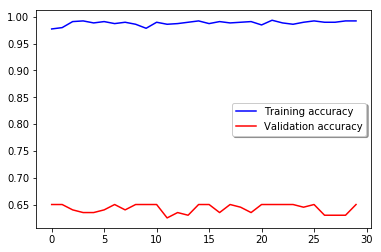

In [71]:
score, acc = model.evaluate(X_train, y_train, batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Plot the accuracy curves for training and validation 
pyplot.plot(history.history['acc'], color='b', label="Training accuracy")
pyplot.plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = pyplot.legend(loc='best', shadow=True)